> "We aim to develop a completely open file format flexible enough to store any possible type of electron microscopy data, while also allowing metadata of any type to be included."
>> Colin Ophus, https://emdatasets.com/format/


#  `emd` package basic example

This notebook demos basic use of the `emd` package. `emd` defines a set of classes which interface between long term storage (HDF5 files) and Python runtime objects.  The intention is to simplify the i/o step of any data analysis workflow, while encouraging organized (and therefore more useful) data processing artifact handling and storage.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from py4DSTEM import emd

In [3]:
# Utility for cleaning a filepath

fp = "/Users/Ben/Desktop/test.h5"

from os.path import exists
from os import remove

def clean():
    if exists(fp):
        remove(fp)
clean()

## The example

As our purpose in to see the `emd` io functionality in action, the data itself is somewhat arbitrary - still, to evaluate the utility of the package, data which at least mirrors the form of some simple experiment is in order.  Let's say we have 3D signals, consisting of a stack of 2D images.  Maybe they're a time series.  Each image has some noisy gaussian, which moves from one image to the next.

In [4]:
# Generate data

import numpy as np
from scipy.stats import poisson

shape = (256,256,8)

class DataGenerator:
    
    params = {'A':5, 'sigx':12, 'sigy':9}  # 2D gaussian params
    mu_scale = 1                           # scaling for Poisson draws
    
    def __init__(self, xy0, v0):
        """ 2-tuples xy0 and v0
        """
        
        # set the initial position and velocity
        self.xy0 = np.array(xy0)
        self.v0 = np.array(v0)

        # find the center at each time point
        self.xy = self.xy0[:,np.newaxis] + \
            np.tile(np.arange(8),(2,1))*self.v0[:,np.newaxis]
        
        # make the data
        self.generate_data()


    def generate_data(self):
        
        # make a meshgrid
        yy,xx = np.meshgrid(np.arange(shape[1]),np.arange(shape[0]))
        self.xx,self.yy = xx-shape[0]/2., yy - shape[1]/2.
        
        # extend in the third dimension and center
        self.xx = np.dstack([ self.xx[:,:,np.newaxis] - x for x in self.xy[0,:] ])
        self.yy = np.dstack([ self.yy[:,:,np.newaxis] - y for y in self.xy[1,:] ])
        
        # get the data
        
        #print(DataGenerator.params)
        
        self.data = poisson.rvs(
            self.gaussian((self.xx,self.yy), **(DataGenerator.params)) * DataGenerator.mu_scale
        )
    
    @staticmethod
    def gaussian(p,A,sigx,sigy):
        return A * np.exp(-(0.5*(p[0]/sigx)**2)) * np.exp(-(0.5*(p[1]/sigy)**2))


# generate some data
xy0 = (-17,-9)
v0 = (6,8)
data_generator = DataGenerator(xy0, v0)

## Analysis - first pass

With some data in hand, lets do some simple analysis.  We'll visualize the data, then take the mean, max, and standard deviations across the 3rd dimension, and we'll find the the center of mass for each 2D image.

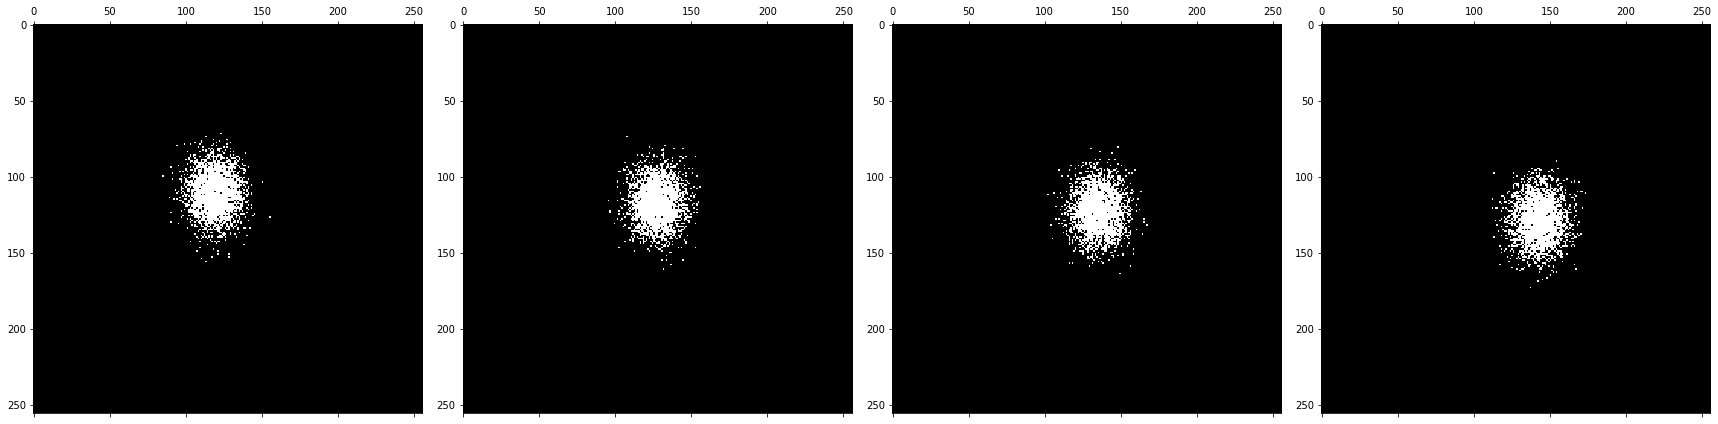

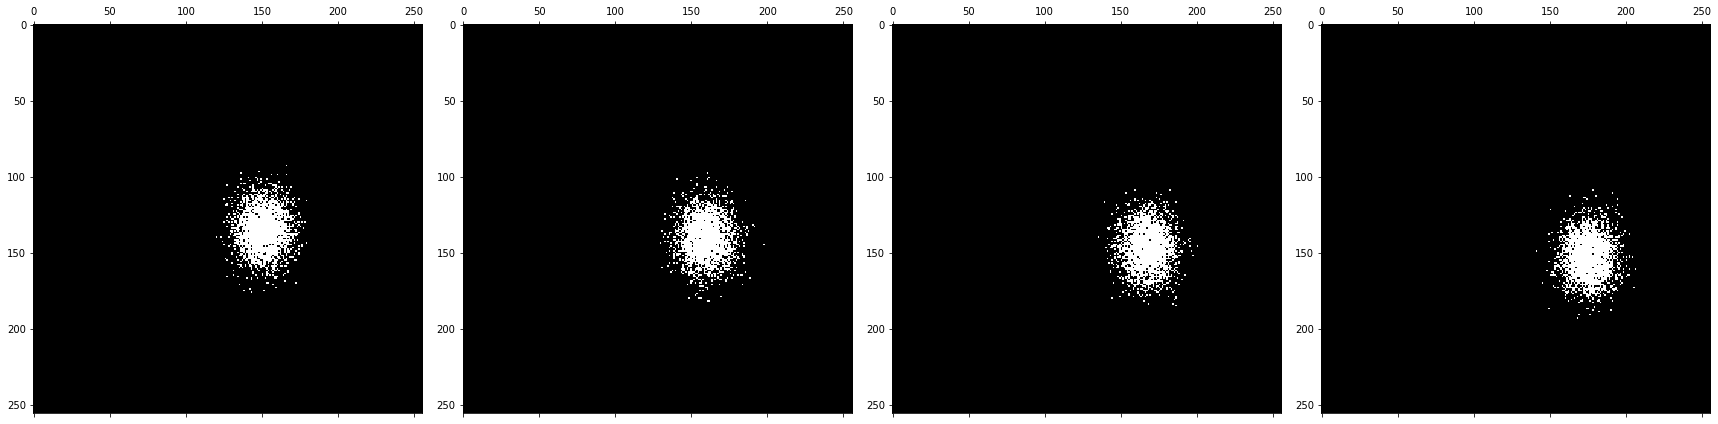

In [5]:
# visualize the data

from py4DSTEM.visualize import show

show([data_generator.data[:,:,idx] for idx in [0,1,2,3]])
show([data_generator.data[:,:,idx] for idx in [4,5,6,7]])

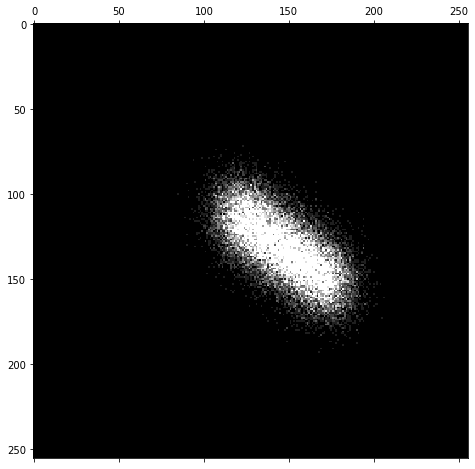

In [6]:
# The mean

show(np.mean(data_generator.data,axis=2))

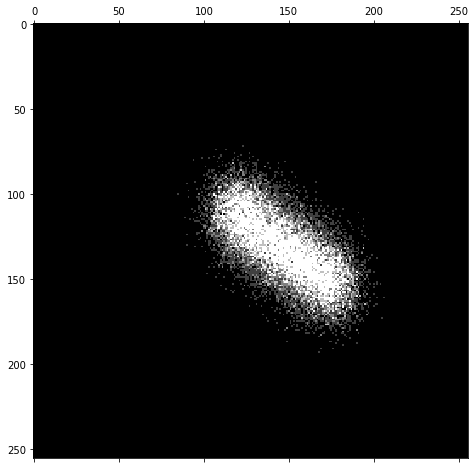

In [7]:
# The max

show(np.max(data_generator.data,axis=2))

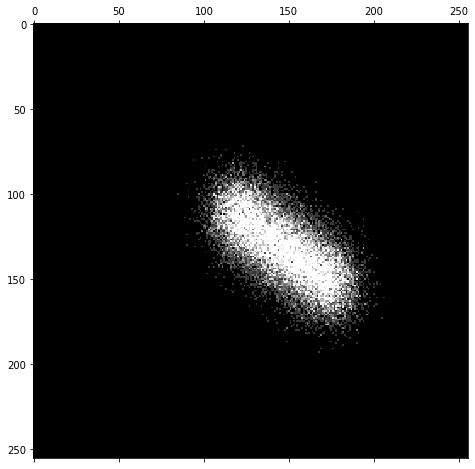

In [8]:
# The std

show(np.std(data_generator.data,axis=2))

In [9]:
# The CoM

def get_com(im):
    tot = np.sum(im)
    yy,xx = np.meshgrid(np.arange(shape[1]),np.arange(shape[0]))
    return (np.sum(xx*im)/tot, np.sum(yy*im)/tot)

com = get_com(data_generator.data[:,:,0])
com

(110.8067396313364, 119.01699308755761)

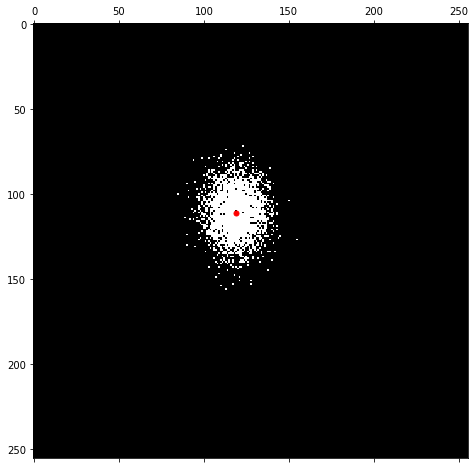

In [10]:
show(data_generator.data[:,:,0],points={'x':com[0],'y':com[1]})

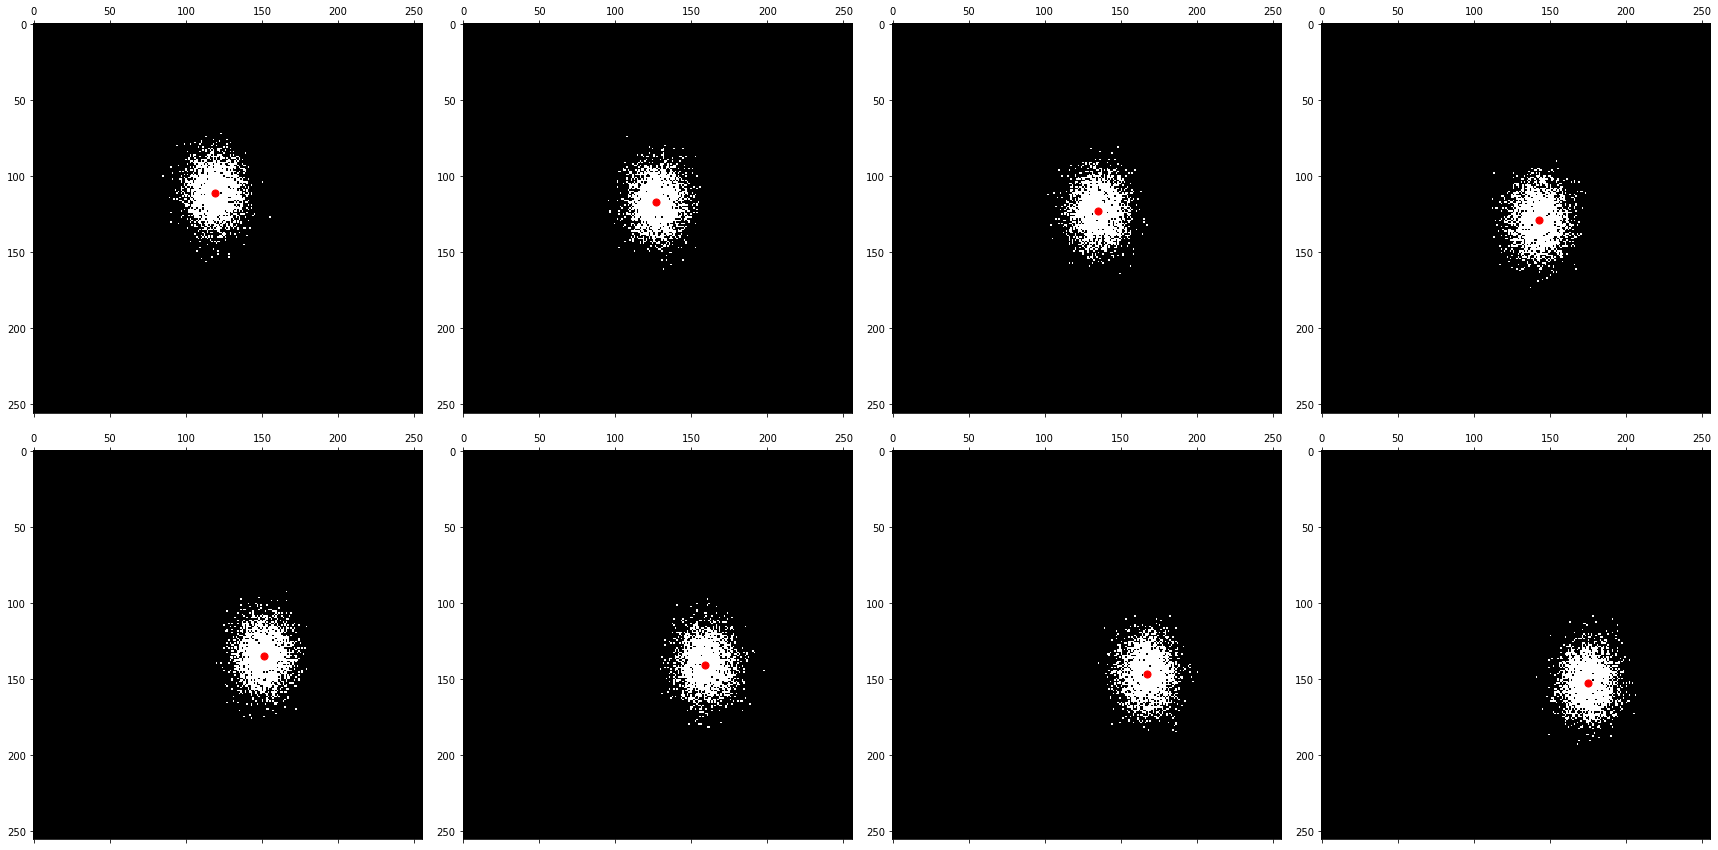

In [11]:
coms = np.array([get_com(data_generator.data[:,:,i]) for i in range(shape[2])]).T

from py4DSTEM.visualize import show_image_grid
show_image_grid(
    lambda i:data_generator.data[:,:,i],
    H=2,W=4,
    get_x = lambda i: coms[0,i],
    get_y = lambda i: coms[1,i],
)

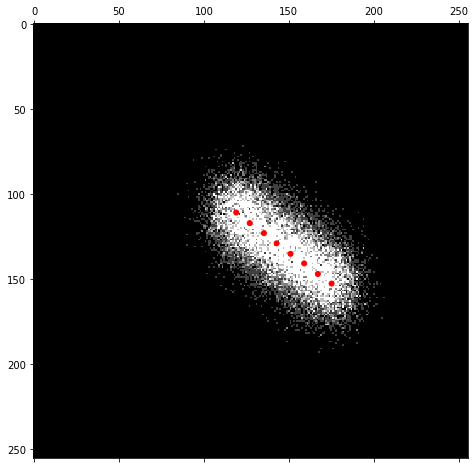

In [12]:
show(
    np.max(data_generator.data,axis=2),
    points={'x':coms[0,:],'y':coms[1,:]},
)

## Analysis - second pass

Ok, so we've analyzed one dataset.  Nice work! But you know how it goes - where there's one dataset, there's usually two...or three...or ten...

...or 10,000.  So maybe we want to automate things a little more.  In Python we might do that by defining a class - let's see what that looks like here.

In [13]:
# Define the analysis class

class SomeWorkflow:
    """
    Analysis for A Very Important Investigation into the Apparent Motion of Fuzzy Blobs
    """
    
    def __init__(self, name, data):
        """
        """
        self.name = name
        self.data = data

        
    # analysis methods
        
    def get_max(self):
        self.max = np.max(self.data,axis=2)
    def get_mean(self):
        self.mean = np.mean(self.data,axis=2)
    def get_std(self):
        self.std = np.std(self.data,axis=2)
    
    @staticmethod
    def get_com(im):
        tot = np.sum(im)
        yy,xx = np.meshgrid(np.arange(shape[1]),np.arange(shape[0]))
        return (np.sum(xx*im)/tot, np.sum(yy*im)/tot)
    
    def get_coms(self):
        self.coms = np.array([get_com(self.data[:,:,i]) for i in range(shape[2])]).T


In [14]:
# and analysis of the prior dataset becomes...


# instantiate
my_analysis = SomeWorkflow(
    name='1st_try',
    data=data_generator.data
)

# analyze
my_analysis.get_max()
my_analysis.get_mean()
my_analysis.get_std()
my_analysis.get_coms()

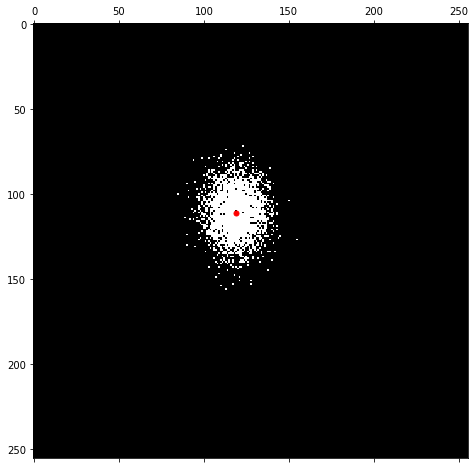

In [15]:
# while visualization is roughly unchanged, e.g. -

show(
    my_analysis.data[:,:,0],
    points={'x':my_analysis.coms[0,0],'y':my_analysis.coms[1,0]}
)

# Saving data

Ok, you might be saying, this is all well and good, but what about saving my results?  After all, what good is any of this if I can't store and retrieve the information later?!  Luckily, `emd` is here.

In [16]:
# Define a new, improved analysis class

class SaveableWorkflow:
    """
    Analysis and io for A Very Important Experiment
    """
    
    def __init__(self, name, data):
        """
        """
        self.name = name
        self.data = data

        
    # analysis methods
        
    def get_max(self):
        self.max = np.max(self.data,axis=2)
    def get_mean(self):
        self.mean = np.mean(self.data,axis=2)
    def get_std(self):
        self.std = np.std(self.data,axis=2)
    
    @staticmethod
    def get_com(im):
        tot = np.sum(im)
        yy,xx = np.meshgrid(np.arange(shape[1]),np.arange(shape[0]))
        return (np.sum(xx*im)/tot, np.sum(yy*im)/tot)
    
    def get_coms(self):
        self.coms = np.array([get_com(self.data[:,:,i]) for i in range(shape[2])]).T


    
    # io methods
    
    def build_tree(self):
        
        # make a new tree root
        self.root = emd.Root( name=self.name )
        
        # wrap the derived data in emd classes
        ar_max = emd.Array( name='max', data=self.max)
        ar_mean = emd.Array( name='mean', data=self.mean)
        ar_std = emd.Array( name='std', data=self.std)
        ar_coms = emd.Array( name='coms', data=self.coms )
        
        # build the tree
        self.root.tree( ar_max )
        self.root.tree( ar_mean )
        self.root.tree( ar_std )
        self.root.tree( ar_coms )
    
    def save(self):
        self.build_tree()
        if not exists(fp):
            emd.save(fp, self.root)
        else:
            emd.save(fp, self.root, mode='a')

In [17]:
del(my_analysis)
clean()

In [18]:
# our analysis is the same as above, except...


# ((instantiate))
my_analysis = SaveableWorkflow(
    name='1st_try',
    data=data_generator.data
)

# ((analyze))
my_analysis.get_max()
my_analysis.get_mean()
my_analysis.get_std()
my_analysis.get_coms()


# ...this time we can save it....
my_analysis.save()

In [19]:
# We can look at the contents of the file without loading anything

emd.print_h5_tree(fp)

/
|--1st_try
	|--coms
	|--max
	|--mean
	|--std




In [20]:
# And we can load the data

loaded_data = emd.read(fp)

In [21]:
# The data is accessible as

ar_max = loaded_data.tree('max')
ar_mean = loaded_data.tree('mean')
ar_std = loaded_data.tree('std')
ar_coms = loaded_data.tree('coms')

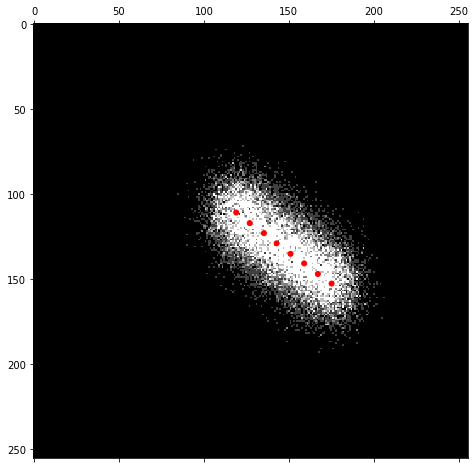

In [22]:
# And can be visualized as before

show(
    ar_max,
    points={'x':ar_coms[0,:],'y':ar_coms[1,:]}
)

In [23]:
# Notice that the data itself are no longer numpy ndarrays - they are emd Arrays.
# Which is essentially a numpy array, but better

ar_mean

Array( A 2-dimensional array of shape (256, 256) called 'mean',
       with dimensions:

       dim0 = [0,1,...] pixels
       dim1 = [0,1,...] pixels
)

# Many datasets to one file

Here we demonstrate saving the outputs of our workflow from many datasets.  Let's imagine our data really is a time series, and that our fuzzy blobs all seemed to be moving at some velocity, which is random, but seems like it may have some bias, which maybe is interesting for some reason.  Let's see if we can identify and perhaps quantify any such bias.

In [24]:
clean()

In [25]:
# Generate 100 datasets

from scipy.stats import uniform,cosine

centers = uniform.rvs(-10,20,size=(2,100))  # uniform distribution from -10 to 10
vmag = uniform.rvs(0,10,size=100)           # uniform distribution from 0 to 10
vang = cosine.rvs(0,np.pi/4,size=100)       # cosine distribution from -pi/2 to pi/2
velocities = np.vstack(
    [vmag*np.sin(vang),
     vmag*np.cos(vang)]
)


datasets = []
for idx in range(100):
    
    datasets.append( DataGenerator(centers[:,idx], velocities[:,idx]) )

In [26]:
# Run analysis on each dataset

for idx in range(100):
    
    # instantiate
    my_analysis = SaveableWorkflow(
        name = f'experiment_{idx}',
        data = datasets[idx].data
    )

    # analyze
    my_analysis.get_max()
    my_analysis.get_mean()
    my_analysis.get_std()
    my_analysis.get_coms()
    
    # and save
    my_analysis.save()

In [27]:
# The tree for this HDF5 file is large...

emd.print_h5_tree(fp)

/
|--experiment_0
|	|--coms
|	|--max
|	|--mean
|	|--std
|--experiment_1
|	|--coms
|	|--max
|	|--mean
|	|--std
|--experiment_10
|	|--coms
|	|--max
|	|--mean
|	|--std
|--experiment_11
|	|--coms
|	|--max
|	|--mean
|	|--std
|--experiment_12
|	|--coms
|	|--max
|	|--mean
|	|--std
|--experiment_13
|	|--coms
|	|--max
|	|--mean
|	|--std
|--experiment_14
|	|--coms
|	|--max
|	|--mean
|	|--std
|--experiment_15
|	|--coms
|	|--max
|	|--mean
|	|--std
|--experiment_16
|	|--coms
|	|--max
|	|--mean
|	|--std
|--experiment_17
|	|--coms
|	|--max
|	|--mean
|	|--std
|--experiment_18
|	|--coms
|	|--max
|	|--mean
|	|--std
|--experiment_19
|	|--coms
|	|--max
|	|--mean
|	|--std
|--experiment_2
|	|--coms
|	|--max
|	|--mean
|	|--std
|--experiment_20
|	|--coms
|	|--max
|	|--mean
|	|--std
|--experiment_21
|	|--coms
|	|--max
|	|--mean
|	|--std
|--experiment_22
|	|--coms
|	|--max
|	|--mean
|	|--std
|--experiment_23
|	|--coms
|	|--max
|	|--mean
|	|--std
|--experiment_24
|	|--coms
|	|--max
|	|--mean
|	|--std
|--experime

In [28]:
# Later we can come back and load the data...

loaded_data = emd.read(fp)

Multiple root groups detected - returning root names. Please specify the `emdpath` argument. Returning the list of rootgroups.


In [29]:
loaded_data

['experiment_0',
 'experiment_1',
 'experiment_10',
 'experiment_11',
 'experiment_12',
 'experiment_13',
 'experiment_14',
 'experiment_15',
 'experiment_16',
 'experiment_17',
 'experiment_18',
 'experiment_19',
 'experiment_2',
 'experiment_20',
 'experiment_21',
 'experiment_22',
 'experiment_23',
 'experiment_24',
 'experiment_25',
 'experiment_26',
 'experiment_27',
 'experiment_28',
 'experiment_29',
 'experiment_3',
 'experiment_30',
 'experiment_31',
 'experiment_32',
 'experiment_33',
 'experiment_34',
 'experiment_35',
 'experiment_36',
 'experiment_37',
 'experiment_38',
 'experiment_39',
 'experiment_4',
 'experiment_40',
 'experiment_41',
 'experiment_42',
 'experiment_43',
 'experiment_44',
 'experiment_45',
 'experiment_46',
 'experiment_47',
 'experiment_48',
 'experiment_49',
 'experiment_5',
 'experiment_50',
 'experiment_51',
 'experiment_52',
 'experiment_53',
 'experiment_54',
 'experiment_55',
 'experiment_56',
 'experiment_57',
 'experiment_58',
 'experiment_59'

In [32]:
# Let's try to solve the case of the mysterious motion of the blurred blob...

orientations = np.empty(100)

for idx,rootname in enumerate(loaded_data):   # loop through all the experiments
    
    root = emd.read(fp, emdpath=rootname)     # open this experiment
    coms = root.tree('coms')                  # get the centers of mass
    v_mean = coms[:,-1] - coms[:,0]           # determine the velocity orientation
    orientations[idx] = np.angle(-1j*v_mean[0]+v_mean[1])


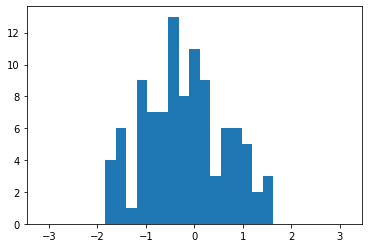

In [33]:
# Aha!  It was biased all along

import matplotlib.pyplot as plt

fig,ax = plt.subplots()
ax.hist(orientations, bins=np.linspace(-np.pi,np.pi,30))
plt.show()